In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import AutoMinorLocator

import seaborn as sns

import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, pipeline, manifold, cluster

import lightgbm as lgb

import scikitplot as skplt

In [3]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Valeurs Manquantes', 1 : '% des données totales'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% des données totales', ascending=False).round(1)
        
        # Print some summary information
        print ("Le dataframe a " + str(df.shape[1]) + " colonnes.\n"      
            "Il y a  " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes avec des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
# Affichage de la distribution par subset
def distribSubset(df, subset, numcols):
    if len(numcols)%2 ==0:
        l = len(numcols)//2
    else: l = (len(numcols)//2)+1
        
    fig, ax = plt.subplots(l,2)
    fig.set_size_inches(20, 20)
    i=1

    for a in numcols:
        ax = plt.subplot(l,2,i)
        plt.subplots_adjust()
        plt.xticks(rotation = 90)
        ax = sns.boxplot(x=subset, y=a, data=df)
        i+=1

# Affichage de la matrice de corrélations
def pearsonMatrix(df, annot):
    df_pearson = df.corr(method='pearson').copy()
    plt.figure(figsize=(13,10))
    if annot ==1:
        sns.heatmap(df_pearson, linewidth=0.5,annot=True,annot_kws={"size": 8, "animated":0}, cmap="YlGnBu")
    else:
        sns.heatmap(df_pearson, linewidth=0.5,annot=False, cmap="YlGnBu")
        
    
def encoding_str_data(df_train, df_test):
    '''
    - Assuming train & test have the same columns
    - Lists all columns.
    - The ones that have 2 or less choices are passed on to a LabelEncoder with a fit on train data
    and a transform on both train & test to make sure that transformation is replicable.
    - All other columns with a dtype = 'object' are encoded with OneHotEncoder

    WARNING : this function will replace given columns by encoded ones !
    Make sure you keep a copy of the original data if you need it
    '''

    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    import pandas as pd

    le = LabelEncoder()
    le_count = 0

    nb_col_str = len(df_train.select_dtypes(include='object').columns)

    for col in df_train:
        if df_train[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(df_train[col].unique()) <= 2:
                # Train on the training data
                le.fit(df_train[col])
                # Transform both training and testing data
                df_train[col] = le.transform(df_train[col])
                df_test[col] = le.transform(df_test[col])

                # Keep track of how many columns were label encoded
                le_count += 1

    # one-hot encoding of categorical variables
    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test)

    print('%d columns were label encoded.' % le_count)
    print('%d columns were one-hot encoded.' % (nb_col_str-le_count))
    print('Training Features shape: ', df_train.shape)
    print('Testing Features shape: ', df_test.shape)
    
    return df_train, df_test


def align_columns(df_train, df_test):
    '''
    To be used after string encoding.
    This function will align train & test datasets to make sure they have the same columns.
    '''
    train_labels = df_train['TARGET']

    # Align the training and testing data, keep only columns present in both dataframes
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

    # Add the target back in
    df_train['TARGET'] = train_labels

    print('Training Features shape: ', df_train.shape)
    print('Testing Features shape: ', df_test.shape)
    
    return df_train, df_test
    
    
def anomalies_employed_days(df):
    '''
    Detects the anomaly where days_employed has a max of 365 243 days.
    Creates a new column to flag the anomaly and replaces the original values with nan.
    '''
    if df['DAYS_EMPLOYED'].max() == 365243:
        # Create an anomalous flag column
        df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
        # Replace the anomalous values with nan
        df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

        
def printBoxplots(df):
    '''
    Print boxplots for quantitative columns in df.        
    '''
    for col in df:
        df.boxplot(column=col, vert=False)
        plt.show()        


def distributionPlots(df, annot):
    '''
    Plots distributions for quantitative columns in df.
    annot = True if you want AVG & MED values added as a box in the top right corner
    '''
    global fig
    numeric_cols = [col for col in df.columns if df[col].dtype in ('float', 'int')]
    X = df[numeric_cols].values
    if len(df[numeric_cols].columns) > 15:
        fig = plt.figure(figsize=(15,30))
    else: fig = plt.figure(figsize=(15,15))
    
    if annot: 
        for feat_idx in range(df[numeric_cols].shape[1]):
            AVG = X[:, feat_idx].mean()
            MED = np.median(X[:, feat_idx])
            ax = fig.add_subplot((len(df[numeric_cols].columns)//2)+1,3,feat_idx+1)
            h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
            at = AnchoredText(('AVG = %.0f' % AVG + '\nMED = %.0f' % MED), prop=dict(size=10), frameon=True,loc='upper right')
            at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(at)
            ax.set_title(df[numeric_cols].columns[feat_idx], fontsize=14)
        fig.subplots_adjust(hspace=0.9)
    else:
        for feat_idx in range(df[numeric_cols].shape[1]):
            ax = fig.add_subplot((len(df[numeric_cols].columns)//2)+1,3,feat_idx+1)
            h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
            ax.set_title(df[numeric_cols].columns[feat_idx], fontsize=14)
        fig.subplots_adjust(hspace=0.9)

        
def pipeline_maker(imputer, scaler, estimator):
    '''
    Creates a pipeline based on an imputer, scaler and estimator
    Returns the pipeline ready to fit.
    '''    

    pipe = pipeline.Pipeline([('imputer', imputer),('scaler', scaler), ('estimator', estimator)])
    
    return pipe

In [4]:
# Nom du dossier où sont stockées les données fournies

path_csv = '/home/romain/Bureau/Formation OpenClassrooms/Projet 07 - Implémentez un modèle de scoring/Projet+Mise+en+prod+-+home-credit-default-risk/'

pd.set_option('display.max_rows', None)


### Définition du risque

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).


Nous allons commencer par définir ce qu'est le défaut de paiement du client, à travers l'exploration des données.

In [5]:
# Import automatique des fichiers, à l'exception de celui contenant la description des variables

files_list = os.listdir(path_csv)
names = []
files_list.remove('HomeCredit_columns_description.csv')

for file in files_list:
    name = str(file).split('.csv')[0]
    names.append(name)

z=0
files_ready=[]
for f,r in zip(names,files_list):
    globals()[f]=pd.read_csv(path_csv+r)        
    files_ready.append(f)
    z+=1

Les 2 fichiers 'applications_train' et 'applications_test' contiennent les éléments des dossiers de demandes de crédit. Dans le fichier 'train', on retrouve une variable 'Target', absente du fichier de test. C'est cette variable que nous allons chercher à prédire.

Le fichier de description nous indique que la valeur 1 correspond au risque de défaut, le 0 à toutes les autres situations. Nous allons donc construire un modèle de

In [5]:
application_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511,NaN,NaN,NaN,278181,102790,100002,189146,278202,367142,456255
TARGET,307511,NaN,NaN,NaN,0.0807288,0.272419,0,0,0,0,1
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,307511,2,Y,213312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,307511,NaN,NaN,NaN,0.417052,0.722121,0,0,0,1,19
AMT_INCOME_TOTAL,307511,NaN,NaN,NaN,168798,237123,25650,112500,147150,202500,1.17e+08
AMT_CREDIT,307511,NaN,NaN,NaN,599026,402491,45000,270000,513531,808650,4.05e+06
AMT_ANNUITY,307499,NaN,NaN,NaN,27108.6,14493.7,1615.5,16524,24903,34596,258026


In [6]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   SK_ID_CURR                    int64  
 1   TARGET                        int64  
 2   NAME_CONTRACT_TYPE            object 
 3   CODE_GENDER                   object 
 4   FLAG_OWN_CAR                  object 
 5   FLAG_OWN_REALTY               object 
 6   CNT_CHILDREN                  int64  
 7   AMT_INCOME_TOTAL              float64
 8   AMT_CREDIT                    float64
 9   AMT_ANNUITY                   float64
 10  AMT_GOODS_PRICE               float64
 11  NAME_TYPE_SUITE               object 
 12  NAME_INCOME_TYPE              object 
 13  NAME_EDUCATION_TYPE           object 
 14  NAME_FAMILY_STATUS            object 
 15  NAME_HOUSING_TYPE             object 
 16  REGION_POPULATION_RELATIVE    float64
 17  DAYS_BIRTH                    int64  
 18  DAYS_EMPLOYED          

0    282686
1     24825
Name: TARGET, dtype: int64


<AxesSubplot:ylabel='Frequency'>

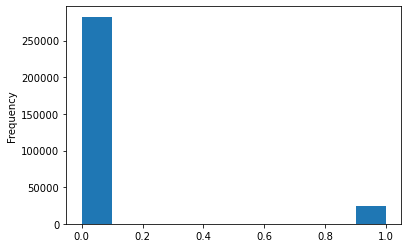

In [106]:
# Répartition des targets 1 et 0 dans le jeu d'entraînement

print(application_train['TARGET'].value_counts())

application_train['TARGET'].astype(int).plot.hist()

In [102]:
# Affichage des colonnes comportant des valeurs manquantes
    
missing_values_table(application_train)

Le dataframe a 122 colonnes.
Il y a  67 colonnes avec des valeurs manquantes.


,Valeurs Manquantes,% des données totales
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [103]:
# Nombre de colonnes de chaque type
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Nous allons donc avoir un travail d'imputation et/ou de sélection à réaliser sur les colonnes comportant trop de NaN, ainsi qu'un travail d'encodage pour les données fournies au format str.

In [104]:
# Nombre de catégories uniques par colonnes str
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Les catégories avec 2 occurrences sont en fait des booléns que nous pouvons encoder en (0,1). Pour les autres nous utiliserons OneHotEncoder

In [6]:
print('Age Min : ', application_train.DAYS_BIRTH.min()/365)
print('Age Max : ', application_train.DAYS_BIRTH.max()/365)
print('Durée Travail Min : ', application_train.DAYS_EMPLOYED.min()/365)
print('Durée Travail Max : ', application_train.DAYS_EMPLOYED.max()/365)


Age Min :  -69.12054794520547
Age Max :  -20.517808219178082
Durée Travail Min :  -49.07397260273972
Durée Travail Max :  1000.6657534246575


365243

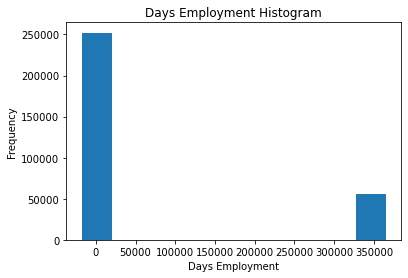

In [16]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');


application_train['DAYS_EMPLOYED'].max()

In [5]:
correlations = application_train.corr()['TARGET'].sort_values()

In [6]:
correlations

EXT_SOURCE_3                   -0.178919
EXT_SOURCE_2                   -0.160472
EXT_SOURCE_1                   -0.155317
DAYS_EMPLOYED                  -0.044932
FLOORSMAX_AVG                  -0.044003
FLOORSMAX_MEDI                 -0.043768
FLOORSMAX_MODE                 -0.043226
AMT_GOODS_PRICE                -0.039645
REGION_POPULATION_RELATIVE     -0.037227
ELEVATORS_AVG                  -0.034199
ELEVATORS_MEDI                 -0.033863
FLOORSMIN_AVG                  -0.033614
FLOORSMIN_MEDI                 -0.033394
LIVINGAREA_AVG                 -0.032997
LIVINGAREA_MEDI                -0.032739
FLOORSMIN_MODE                 -0.032698
TOTALAREA_MODE                 -0.032596
ELEVATORS_MODE                 -0.032131
LIVINGAREA_MODE                -0.030685
AMT_CREDIT                     -0.030369
APARTMENTS_AVG                 -0.029498
APARTMENTS_MEDI                -0.029184
FLAG_DOCUMENT_6                -0.028602
APARTMENTS_MODE                -0.027284
LIVINGAPARTMENTS

Pas de corrélation élevée observée sur le dataset, la plus importante semble être la relation entre l'âge du demandeur de crédit et l'obtention du prêt, avec une faible corrélation négative (-0.17).

Le graphique ci-dessous (pas de moi) illustre extrêmement bien cette relation inverse

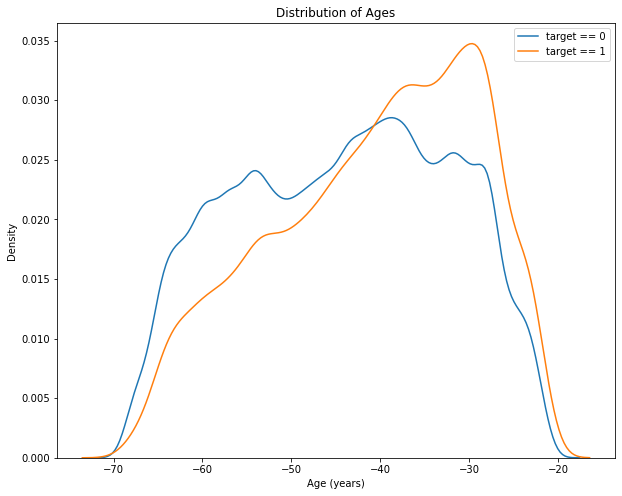

In [26]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()

plt.show()

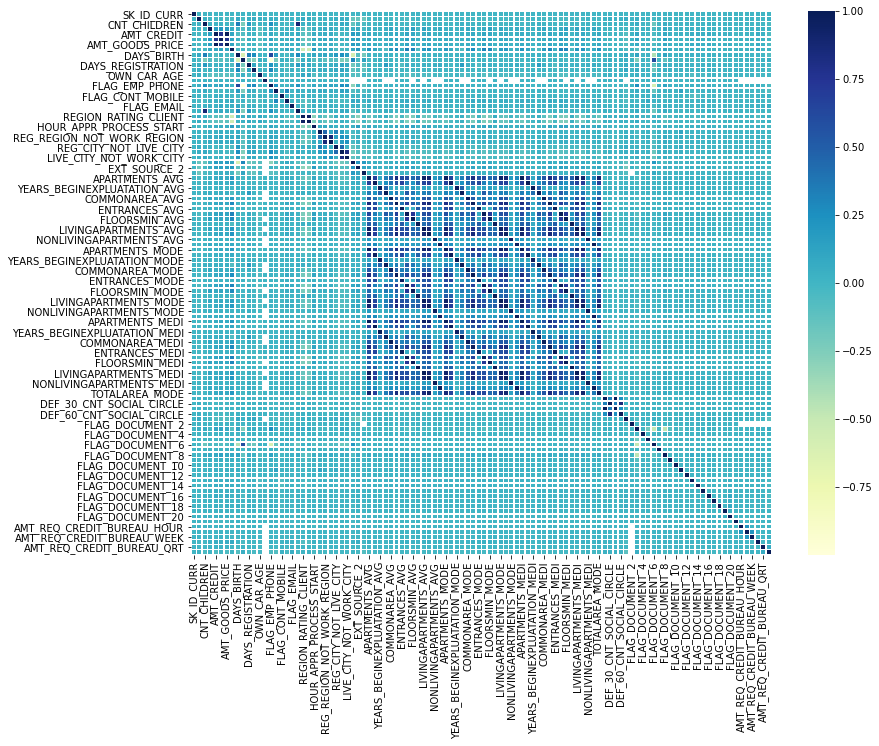

In [28]:
# Etude de la corrélation des variables entre elles
pearsonMatrix(application_train, 0)


La matrice de corrélation étant illisible en l'état, nous allons commencer par traiter quelques éléments manuellement

In [30]:
application_train.corr().unstack().sort_values().drop_duplicates()


FLAG_EMP_PHONE                DAYS_EMPLOYED                  -0.999755
DAYS_BIRTH                    DAYS_EMPLOYED                  -0.615864
                              EXT_SOURCE_1                   -0.600610
FLAG_DOCUMENT_6               FLAG_EMP_PHONE                 -0.597732
REGION_POPULATION_RELATIVE    REGION_RATING_CLIENT           -0.532877
REGION_RATING_CLIENT_W_CITY   REGION_POPULATION_RELATIVE     -0.531535
FLAG_DOCUMENT_3               FLAG_DOCUMENT_6                -0.486238
                              FLAG_DOCUMENT_8                -0.465730
DAYS_BIRTH                    FLAG_DOCUMENT_6                -0.407160
FLAG_EMP_PHONE                EXT_SOURCE_1                   -0.294147
EXT_SOURCE_2                  REGION_RATING_CLIENT           -0.292895
REGION_RATING_CLIENT_W_CITY   EXT_SOURCE_2                   -0.288299
HOUR_APPR_PROCESS_START       REGION_RATING_CLIENT           -0.285699
DAYS_EMPLOYED                 DAYS_ID_PUBLISH                -0.272378
HOUR_A

In [40]:
# Les colonnes ci-dessous sont trop corrélées à d'autres variables
# Le score risque d'être faussé par ces résultats
# Nous allons les drop

cols_areas = [#'APARTMENTS_AVG',
            'BASEMENTAREA_AVG',
            'YEARS_BEGINEXPLUATATION_AVG',
            'YEARS_BUILD_AVG',
            'COMMONAREA_AVG',
            #'ELEVATORS_AVG',
            #'ENTRANCES_AVG',
            'FLOORSMAX_AVG',
            #'FLOORSMIN_AVG',
            'LANDAREA_AVG',
            #'LIVINGAPARTMENTS_AVG',
            #'LIVINGAREA_AVG',
            'NONLIVINGAPARTMENTS_AVG',
            'NONLIVINGAREA_AVG'
]

cols_to_drop = ['DAYS_EMPLOYED',
                'EXT_SOURCE_1',
                'FLAG_DOCUMENT_6',
                'FLAG_DOCUMENT_8',
                'REGION_POPULATION_RELATIVE',
                'EMERGENCYSTATE_MODE',
                'WALLSMATERIAL_MODE',
                'TOTALAREA_MODE',
                'HOUSETYPE_MODE',
                'FONDKAPREMONT_MODE',
                'NONLIVINGAREA_MEDI',
                'NONLIVINGAPARTMENTS_MEDI',
                'LIVINGAREA_MEDI',
                'LIVINGAPARTMENTS_MEDI',
                'LANDAREA_MEDI',
                'FLOORSMIN_MEDI','FLOORSMAX_MEDI',
                'ENTRANCES_MEDI',
                'ELEVATORS_MEDI','COMMONAREA_MEDI',
                'YEARS_BUILD_MEDI',
                'YEARS_BEGINEXPLUATATION_MEDI',
                'BASEMENTAREA_MEDI','APARTMENTS_MEDI',
                'NONLIVINGAREA_MODE',
                'NONLIVINGAPARTMENTS_MODE',
                'LIVINGAREA_MODE',
                'LIVINGAPARTMENTS_MODE',
                'LANDAREA_MODE',
                'FLOORSMIN_MODE','FLOORSMAX_MODE',
                'ENTRANCES_MODE',
                'ELEVATORS_MODE',
                'COMMONAREA_MODE',
                'YEARS_BUILD_MODE','YEARS_BEGINEXPLUATATION_MODE',
                'BASEMENTAREA_MODE',
                'APARTMENTS_MODE',
                'LIVINGAPARTMENTS_AVG',
                'LIVINGAREA_AVG',
                'APARTMENTS_AVG',
                'FLOORSMIN_AVG',
                'ENTRANCES_AVG',
                'ELEVATORS_AVG',
                'DEF_30_CNT_SOCIAL_CIRCLE',
                'OBS_30_CNT_SOCIAL_CIRCLE',
                'REGION_RATING_CLIENT',
                'REGION_RATING_CLIENT_W_CITY',
                'LIVE_CITY_NOT_WORK_CITY',
                'AMT_ANNUITY',
                'AMT_GOODS_PRICE',
                'CNT_CHILDREN',
                'LIVE_REGION_NOT_WORK_REGION',
                'REG_CITY_NOT_LIVE_CITY',
                'REG_REGION_NOT_WORK_REGION',
                'BASEMENTAREA_AVG',
                'YEARS_BEGINEXPLUATATION_AVG',
                'FLOORSMAX_AVG',
                'FLAG_EMP_PHONE'
]

apptrain = application_train.drop(columns=cols_to_drop)

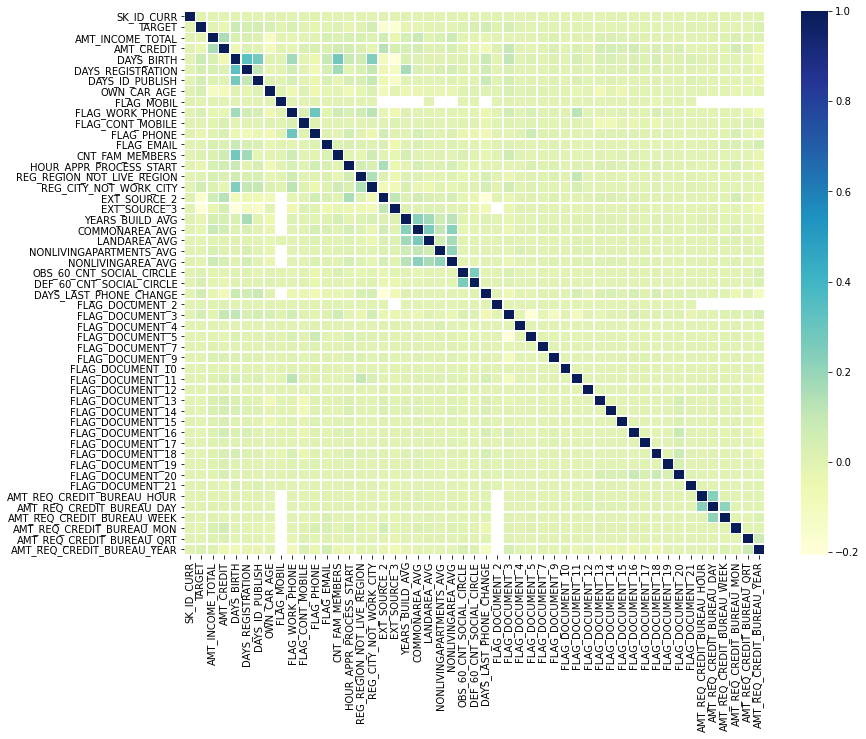

In [41]:
pearsonMatrix(apptrain, 0)

In [42]:
apptrain.corr().unstack().sort_values()

EXT_SOURCE_3                DAYS_BIRTH                   -0.205478
DAYS_BIRTH                  EXT_SOURCE_3                 -0.205478
DAYS_LAST_PHONE_CHANGE      EXT_SOURCE_2                 -0.195764
EXT_SOURCE_2                DAYS_LAST_PHONE_CHANGE       -0.195764
FLAG_DOCUMENT_3             FLAG_DOCUMENT_5              -0.193850
FLAG_DOCUMENT_5             FLAG_DOCUMENT_3              -0.193850
EXT_SOURCE_3                TARGET                       -0.178919
TARGET                      EXT_SOURCE_3                 -0.178919
                            EXT_SOURCE_2                 -0.160472
EXT_SOURCE_2                TARGET                       -0.160472
EXT_SOURCE_3                DAYS_ID_PUBLISH              -0.131597
DAYS_ID_PUBLISH             EXT_SOURCE_3                 -0.131597
OWN_CAR_AGE                 AMT_INCOME_TOTAL             -0.117273
AMT_INCOME_TOTAL            OWN_CAR_AGE                  -0.117273
DAYS_LAST_PHONE_CHANGE      AMT_REQ_CREDIT_BUREAU_YEAR   -0.11

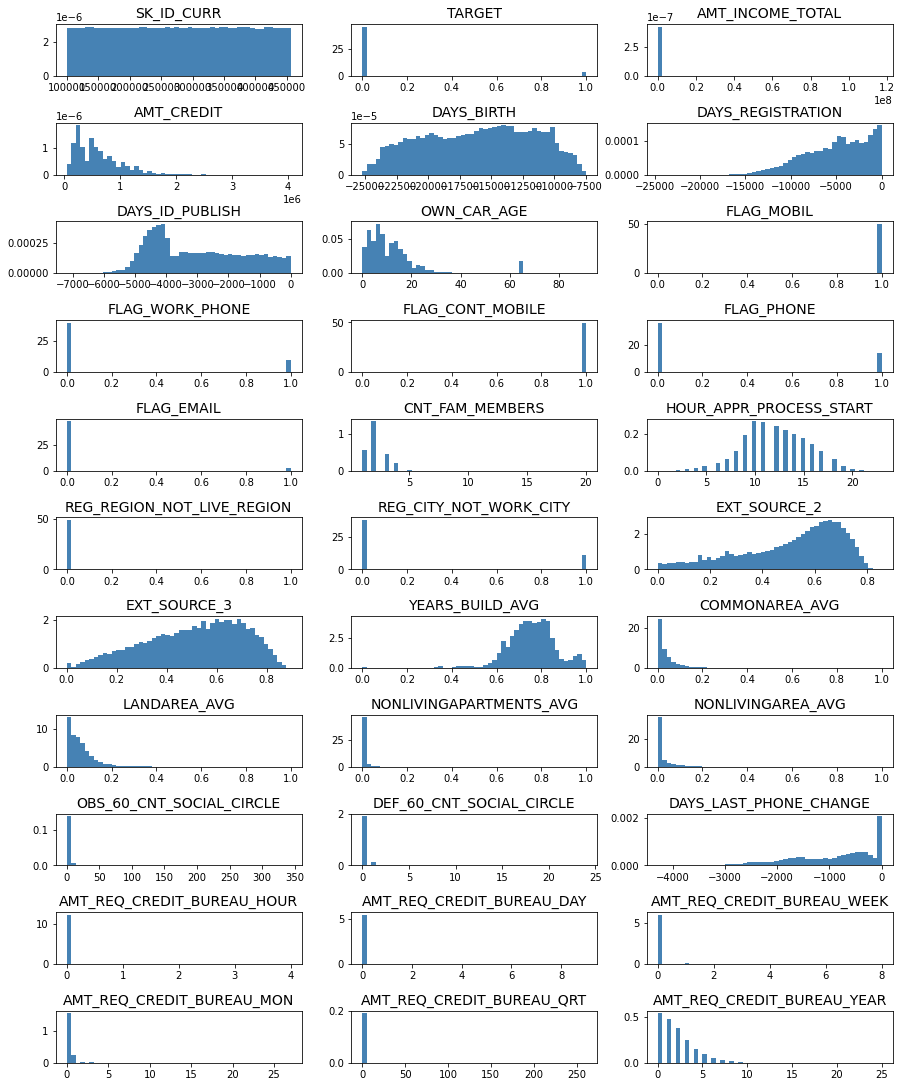

In [88]:
cols_dist = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'LANDAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', #'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       #'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7',
       #'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       #'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       #'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       #'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       #'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']



distributionPlots(apptrain[cols_dist], False)

In [6]:
cols_to_drop = ['DAYS_EMPLOYED',
                'EXT_SOURCE_1',
                'FLAG_DOCUMENT_6',
                'FLAG_DOCUMENT_8',
                'REGION_POPULATION_RELATIVE',
                'EMERGENCYSTATE_MODE',
                'WALLSMATERIAL_MODE',
                'TOTALAREA_MODE',
                'HOUSETYPE_MODE',
                'FONDKAPREMONT_MODE',
                'NONLIVINGAREA_MEDI',
                'NONLIVINGAPARTMENTS_MEDI',
                'LIVINGAREA_MEDI',
                'LIVINGAPARTMENTS_MEDI',
                'LANDAREA_MEDI',
                'FLOORSMIN_MEDI','FLOORSMAX_MEDI',
                'ENTRANCES_MEDI',
                'ELEVATORS_MEDI','COMMONAREA_MEDI',
                'YEARS_BUILD_MEDI',
                'YEARS_BEGINEXPLUATATION_MEDI',
                'BASEMENTAREA_MEDI','APARTMENTS_MEDI',
                'NONLIVINGAREA_MODE',
                'NONLIVINGAPARTMENTS_MODE',
                'LIVINGAREA_MODE',
                'LIVINGAPARTMENTS_MODE',
                'LANDAREA_MODE',
                'FLOORSMIN_MODE','FLOORSMAX_MODE',
                'ENTRANCES_MODE',
                'ELEVATORS_MODE',
                'COMMONAREA_MODE',
                'YEARS_BUILD_MODE','YEARS_BEGINEXPLUATATION_MODE',
                'BASEMENTAREA_MODE',
                'APARTMENTS_MODE',
                'LIVINGAPARTMENTS_AVG',
                'LIVINGAREA_AVG',
                'APARTMENTS_AVG',
                'FLOORSMIN_AVG',
                'ENTRANCES_AVG',
                'ELEVATORS_AVG',
                'DEF_30_CNT_SOCIAL_CIRCLE',
                'OBS_30_CNT_SOCIAL_CIRCLE',
                'REGION_RATING_CLIENT',
                'REGION_RATING_CLIENT_W_CITY',
                'LIVE_CITY_NOT_WORK_CITY',
                'AMT_ANNUITY',
                'AMT_GOODS_PRICE',
                'CNT_CHILDREN',
                'LIVE_REGION_NOT_WORK_REGION',
                'REG_CITY_NOT_LIVE_CITY',
                'REG_REGION_NOT_WORK_REGION',
                'BASEMENTAREA_AVG',
                'YEARS_BEGINEXPLUATATION_AVG',
                'FLOORSMAX_AVG',
                'FLAG_EMP_PHONE'
]

# On conserve une copie des données avant transformation
app_train = application_train.drop(columns=cols_to_drop).copy()
app_test = application_test.drop(columns=cols_to_drop).copy()

In [11]:
app_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 63 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307511 non-null  int64  
 1   TARGET                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE          307511 non-null  object 
 3   CODE_GENDER                 307511 non-null  object 
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   FLAG_OWN_REALTY             307511 non-null  object 
 6   AMT_INCOME_TOTAL            307511 non-null  float64
 7   AMT_CREDIT                  307511 non-null  float64
 8   NAME_TYPE_SUITE             306219 non-null  object 
 9   NAME_INCOME_TYPE            307511 non-null  object 
 10  NAME_EDUCATION_TYPE         307511 non-null  object 
 11  NAME_FAMILY_STATUS          307511 non-null  object 
 12  NAME_HOUSING_TYPE           307511 non-null  object 
 13  DAYS_BIRTH    

## Préparation des données

* Suppression des anomalies éventuelles
* Encodage des données texte
* Préparation des dataset de train & test

In [12]:
# Suppression des anomalies
#anomalies_employed_days(app_train)
#anomalies_employed_days(app_test)

# Encodage des champs texte
app_train, app_test = encoding_str_data(app_train, app_test)

# Alignement des colonnes train & test
app_train, app_test = align_columns(app_train, app_test)


3 columns were label encoded.
9 columns were one-hot encoded.
Training Features shape:  (307511, 172)
Testing Features shape:  (48744, 168)
Training Features shape:  (307511, 169)
Testing Features shape:  (48744, 168)


In [16]:
# Préparation pour la modélisation

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['SK_ID_CURR','TARGET']).copy()
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.drop(columns = ['SK_ID_CURR']).copy()

X_train, X_test, y_train, y_test = train_test_split(train,app_train['TARGET'],test_size=0.2, random_state=30, stratify=app_train['TARGET'])


## Construction du modèle

In [12]:
# Avec une recherche en GridSearchCV

imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

grid = GridSearchCV(LinearSVC(class_weight='balanced'), param_grid = {},cv = 5, scoring='roc_auc')

pipe = pipeline_maker(imputer, scaler, grid)

pipe.fit(X_train, y_train)

print(f"Accuracy = {metrics.accuracy_score(y_test, pipe.predict(X_test)):.3f}")
print(f"ROC_AUC = {pipe.score(X_test, y_test):.2f}")
print(f"F1 Score = {metrics.f1_score(y_test, pipe.predict(X_test), average='weighted'):.2f}")
print(f"Precision = {metrics.precision_score(y_test, pipe.predict(X_test),average='weighted'):.2f}")
print(f"Recall weighted = {metrics.recall_score(y_test, pipe.predict(X_test),average='weighted'):.2f}")
print(f"Recall positive class = {metrics.recall_score(y_test, pipe.predict(X_test),average='binary'):.2f}")


/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to con

Accuracy = 0.686
ROC_AUC = 0.74
F1 Score = 0.76
Precision = 0.89
Recall weighted = 0.69
Recall positive class = 0.66


In [17]:
# Avec une recherche en GridSearchCV

imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

grid = GridSearchCV(lgb.LGBMClassifier(n_estimators=100, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.01, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50), param_grid = {},cv = 5, scoring='roc_auc')

pipe2 = pipeline_maker(imputer, scaler, grid)

pipe2.fit(X_train, y_train)

print(f"Accuracy = {metrics.accuracy_score(y_test, pipe2.predict(X_test)):.3f}")
print(f"ROC_AUC = {pipe2.score(X_test, y_test):.2f}")
print(f"F1 Score = {metrics.f1_score(y_test, pipe2.predict(X_test), average='weighted'):.2f}")
print(f"Precision = {metrics.precision_score(y_test, pipe2.predict(X_test),average='weighted'):.2f}")
print(f"Recall weighted = {metrics.recall_score(y_test, pipe2.predict(X_test),average='weighted'):.2f}")
print(f"Recall positive class = {metrics.recall_score(y_test, pipe2.predict(X_test),average='binary'):.2f}")


Accuracy = 0.687
ROC_AUC = 0.74
F1 Score = 0.76
Precision = 0.89
Recall weighted = 0.69
Recall positive class = 0.67


In [8]:
# Avec une recherche en GridSearchCV

imputer = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=100), param_grid = {},cv = 5, scoring='roc_auc')

pipe3 = pipeline_maker(imputer, scaler, grid)

pipe3.fit(X_train, y_train)

print(f"Accuracy = {metrics.accuracy_score(y_test, pipe3.predict(X_test)):.3f}")
print(f"ROC_AUC = {metrics.roc_auc_score(y_test, pipe3.predict(X_test), average='weighted'):.2f}")
print(f"F1 Score = {metrics.f1_score(y_test, pipe3.predict(X_test), average='weighted'):.2f}")
print(f"Precision = {metrics.precision_score(y_test, pipe3.predict(X_test),average='weighted'):.2f}")
print(f"Recall weighted = {metrics.recall_score(y_test, pipe3.predict(X_test),average='weighted'):.2f}")
print(f"Recall positive class = {metrics.recall_score(y_test, pipe3.predict(X_test),average='binary'):.2f}")


/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/romain/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Accuracy = 0.684
ROC_AUC = 0.67
F1 Score = 0.76
Precision = 0.89
Recall weighted = 0.68
Recall positive class = 0.66


## Choix du modèle

Ici, la décision d'octroi de crédit a une portée importante, en effet un défaut de paiement a un impact important sur les finances de la banque, alors que refuser un prêt ne présente pas de bénéfice marginal très important.

Nous allons donc chercher à entraîner un modèle qui limite autant que possible les 'faux négatifs' (défauts non-prédits), quitte à réduire la précision de notre modèle et à limiter le nombre de crédits octroyés.

Pour cela nous allons utiliser les metrics de Recall et de ROC AUC ainsi que les matrices de confusion

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

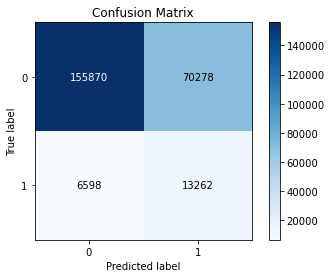

In [13]:
# Matrice de confusion : Linear SVC

skplt.metrics.plot_confusion_matrix(y_train, pipe.predict(X_train))

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

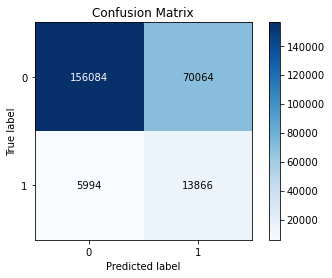

In [18]:
# Matrice de confusion : LGBM Classifier

y_pred = (pipe2.predict_proba(X_train)[:,1] >= 0.5).astype(int)

skplt.metrics.plot_confusion_matrix(y_train, y_pred)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

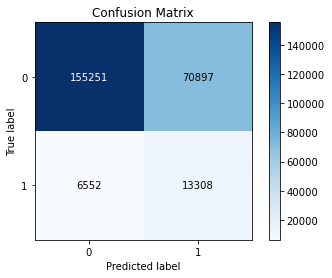

In [15]:
# Matrice de confusion : Logistic Regression

skplt.metrics.plot_confusion_matrix(y_train, pipe3.predict(X_train))

Détermination du seuil de classification pour limiter l'impact des faux négatifs

Une autre possibilité pour améliorer notre modèle est de déterminer dans les paramètres un metrics personnalisé.

Comme vu plus haut, nous allons chercher à 'tordre' le modèle, afin qu'il soit plus performant pour éviter les faux négatifs (très coûteux pour un organisme de prêt) que pour les faux positifs (moins grave).

Nous allons donc utiliser une métrique personnalisée, pour donner plus de poids aux faux négatifs qu'aux faux positifs. Ainsi, en faisant varier le seuil de classification entre classes, nous pourrons minimiser le risque considéré comme 'important' (= celui d'attribuer un crédit à un client à risque de défaut), en limitant au maximum le risque 'acceptable' (= celui de ne pas attribuer de crédit à un client sans risque de défaut)

Nous allons travailler en nous inspirant des propositions de cet article, dans un cas de détermination de fonction de coût pour un problème de classification binaire

Le choix qui est fait est d'attribuer 10x plus de poids au Faux Négatifs qu'aux Faux Positifs, sur le train et le test

https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d

https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb

In [19]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -2*10.0*residual, -2*residual)
    hess = np.where(residual>0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual == 1, 10,(np.where(residual == -1, 1, 0)))
    return np.mean(loss)

scorer = metrics.make_scorer(custom_asymmetric_eval, greater_is_better=False)

In [20]:
grid = GridSearchCV(lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.01, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50), param_grid = {}, cv = 5, scoring='roc_auc')

pipe4 = pipeline_maker(imputer, scaler, grid)

pipe4.fit(X_train, y_train)

print(f"Accuracy = {metrics.accuracy_score(y_test, pipe4.predict(X_test)):.3f}")
print(f"ROC_AUC = {metrics.roc_auc_score(y_test, pipe4.predict(X_test), average='weighted'):.2f}")
print(f"F1 Score = {metrics.f1_score(y_test, pipe4.predict(X_test), average='weighted'):.2f}")
print(f"Precision = {metrics.precision_score(y_test, pipe4.predict(X_test),average='weighted'):.2f}")
print(f"Recall weighted = {metrics.recall_score(y_test, pipe4.predict(X_test),average='weighted'):.2f}")
print(f"Recall positive class = {metrics.recall_score(y_test, pipe4.predict(X_test),average='binary'):.2f}")

Accuracy = 0.730
ROC_AUC = 0.67
F1 Score = 0.79
Precision = 0.89
Recall weighted = 0.73
Recall positive class = 0.59


In [154]:
false_neg = []
false_pos = []
custom_metric = []

thresholds = [x/100 for x in range (20,55,5)]

for thd in thresholds:
    y_pred = (pipe4.predict_proba(X_train)[:,1] >= thd).astype(int)
    truepos = metrics.confusion_matrix(y_train, y_pred)[1][1]
    falneg = metrics.confusion_matrix(y_train, y_pred)[1][0]
    false_neg.append(falneg)
    falpos = metrics.confusion_matrix(y_train, y_pred)[0][1]
    false_pos.append(falpos)
    recall = truepos/(truepos+falneg)
    custom = custom_asymmetric_eval(y_train, y_pred)
    custom_metric.append(custom)
    print("Threshold = ", thd)
    print(f'True Positives = {truepos:,}')
    print(f'False Negatives = {falneg:,}')
    print(f'Recall = {recall:.2%}')
    print(f'False Positives = {falpos:,}')
    print(f'Custom = {custom:,.3f}')
    print('------------------------------------')

Threshold =  0.2
True Positives = 19,839
False Negatives = 21
Recall = 99.89%
False Positives = 162,974
Custom = 0.663
------------------------------------
Threshold =  0.25
True Positives = 19,737
False Negatives = 123
Recall = 99.38%
False Positives = 140,480
Custom = 0.576
------------------------------------
Threshold =  0.3
True Positives = 19,476
False Negatives = 384
Recall = 98.07%
False Positives = 119,658
Custom = 0.502
------------------------------------
Threshold =  0.35
True Positives = 19,028
False Negatives = 832
Recall = 95.81%
False Positives = 100,729
Custom = 0.443
------------------------------------
Threshold =  0.4
True Positives = 18,309
False Negatives = 1,551
Recall = 92.19%
False Positives = 83,584
Custom = 0.403
------------------------------------
Threshold =  0.45
True Positives = 17,367
False Negatives = 2,493
Recall = 87.45%
False Positives = 68,426
Custom = 0.379
------------------------------------
Threshold =  0.5
True Positives = 16,096
False Negativ

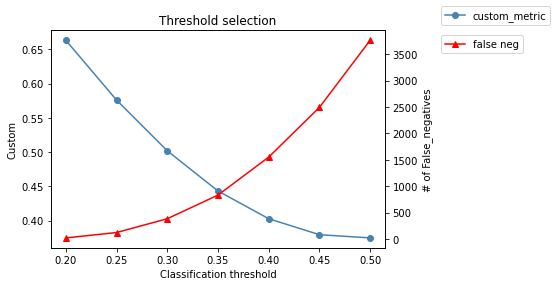

In [156]:
pl = plt.plot(thresholds, custom_metric, marker='o', label = 'custom', color = 'steelblue')
plt.xlabel('Classification threshold')
ax = plt.gca()
ax.set_ylabel('Custom')

plt.legend(pl, ['custom_metric'], bbox_to_anchor=(1.15, 1), loc='lower left')

ax2 = plt.gca().twinx()
pl2 = ax2.plot(thresholds, false_neg, marker='^', label = 'false neg',color = 'red')
ax2.set_ylabel('# of False_negatives')

#pl3 = ax2.plot(thresholds, false_pos, marker='^', label = 'false pos',color = 'green')

plt.title('Threshold selection')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')

plt.show()

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

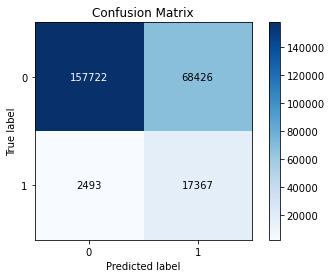

In [21]:
y_pred = (pipe4.predict_proba(X_train)[:,1] >= .45).astype(int)

skplt.metrics.plot_confusion_matrix(y_train, y_pred)

Un seuil de classification à 0.45 semble nous apporter le meilleur rapport entre performance du modèle, limitation du risque, et accueil de nouveaux clients. Notre metric personnalisé nous a permis de prendre une décision basée sur un équilibre des performances.

Affichons ensuite quelques éléments graphiques de compréhension

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.734


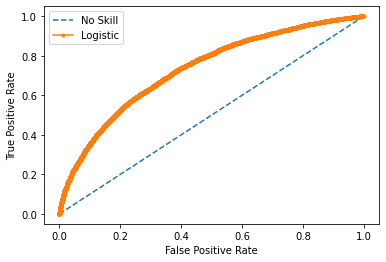

In [168]:
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = pipe4.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

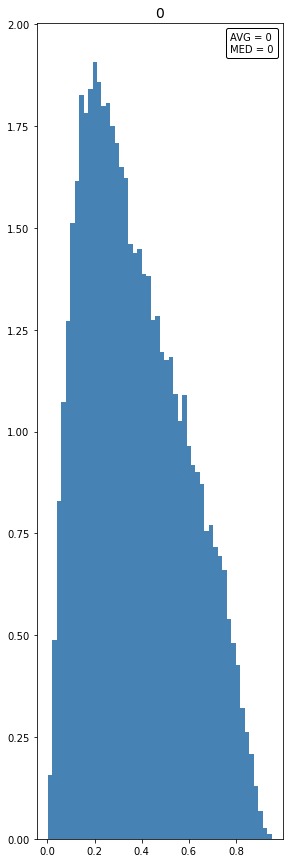

In [169]:
distributionPlots(pd.DataFrame(lr_probs), True)

C'est donc l'utilisation de LightGBM Classifier avec Grid Search, Prétraitement, et un seuil de classification en défaut à 0.45 qui nous apporte les meilleures performances.

Nous utiliserons ce modèle notre Dashboard.

FEATURE IMPORTANCE

In [40]:
estimator = lgb.LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.01, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

pipe5 = pipeline_maker(imputer, scaler, estimator)

pipe5.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('estimator',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                n_estimators=1000, objective='binary',
                                random_state=50, reg_alpha=0.1, reg_lambda=0.01,
                                subsample=0.8))])

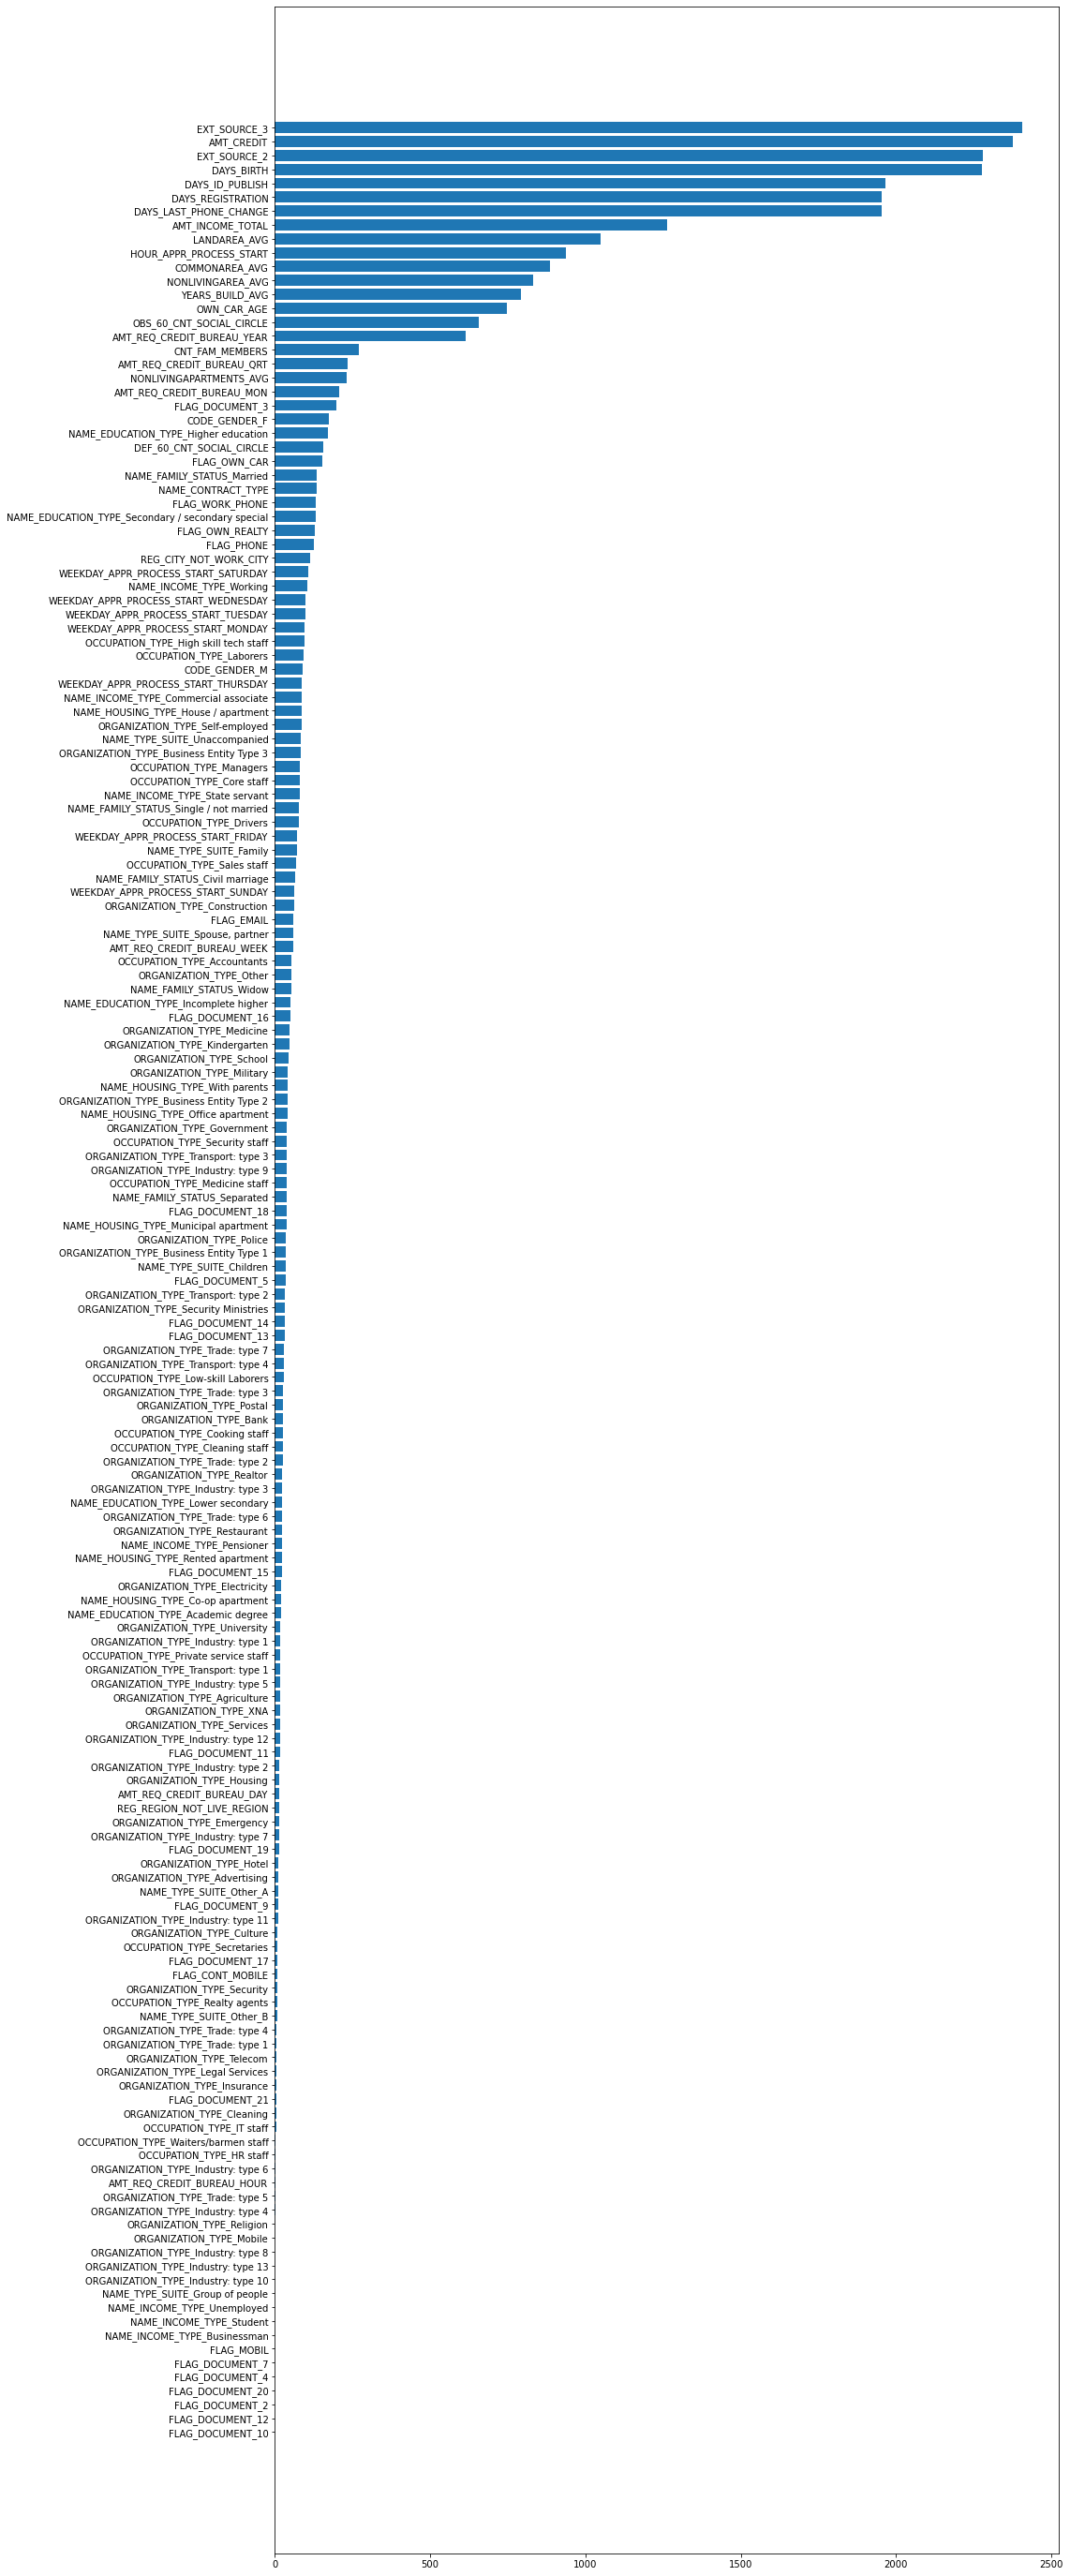

In [60]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['input1', 'input2']
plt.figure(figsize=(15,50))
f_importances(np.abs(pipe5.steps[2][1].feature_importances_), test.columns)

In [64]:
imp, names = zip(*sorted(zip(np.abs(pipe5.steps[2][1].feature_importances_),test.columns)))

In [67]:
importances = pd.DataFrame(imp, names)

In [72]:
importances.sort_values(by=0,ascending=False)

,0
EXT_SOURCE_3,2405
AMT_CREDIT,2376
EXT_SOURCE_2,2279
DAYS_BIRTH,2275
DAYS_ID_PUBLISH,1965
DAYS_REGISTRATION,1955
DAYS_LAST_PHONE_CHANGE,1953
AMT_INCOME_TOTAL,1263
LANDAREA_AVG,1048
HOUR_APPR_PROCESS_START,937


## Dashboard

Pour la préparation des données du dashboard, nous allons opérer une série de calculs afin d'apporter un maximum de précisions à notre application : 
* Regroupement de clients au sein de clusters
* Création de classes d'âge et de niveau de revenu
* Ajout d'informations diverses au dataset de sortie sur lequel sera basé notre dashboard

In [170]:
X_imputed = pipe.steps[0][1].fit_transform(test)
X_transformed = pipe.steps[1][1].fit_transform(X_imputed)

In [171]:
tsne = manifold.TSNE()

X_tsne = tsne.fit_transform(X_transformed)

In [172]:
kmeans = cluster.KMeans(n_clusters=7)

kmeans.fit(X_tsne)

print(metrics.silhouette_score(X_tsne,kmeans.labels_))

0.38565683


In [178]:
y_predict = (pipe4.predict_proba(test)[:,1] >= .45).astype(int)
y_predict_proba = pipe4.predict_proba(test)

In [179]:
application_test['target'] = y_predict
application_test['proba'] = y_predict_proba[:,1]
application_test['cluster'] = kmeans.labels_
application_test['debt_ratio'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']
application_test['age'] = -application_test['DAYS_BIRTH'] / 365

groups = [x/10 for x in range(11)]
groups2 = [x/10 for x in range(7)]
groups3 = [0] + [x*5 for x in range(4,14)] + [np.inf]

application_test["proba_group"] = pd.cut(application_test["proba"], bins=groups, labels =['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])
application_test["debt_group"] = pd.cut(application_test["debt_ratio"], bins=groups2, labels =['0-25','25-50','50-75','75-100','100-150','150+'])
application_test["age_group"] = pd.cut(application_test["age"], bins=groups3, labels =['0-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','60-65','65-70','70+'])


In [180]:
application_test.to_csv('customers_data.csv')

In [6]:
application_test= pd.read_csv('customers_data.csv')

Possibilité d'augmentation de features :
- variables polynomiales
- rajout de données issues d'autres tables du dataset

In [7]:
df_api = application_test[['SK_ID_CURR', 'target']]
df_api = df_api.set_index("SK_ID_CURR")

df_api.to_csv('customers_data_light.csv')